# Sentiment Analysis of Movie Reviews
### GA DSI-SG-26 Capstone
> By: Matthew Lio
---

Project notebook organisation:

1. Data Cleaning and EDA
2. Lexicon-based Models
3. Binary Classification ML Models
4. Deep Learning Models (current notebook)

# 4. Deep Learning Models
---

### Contents:
- [Library and Data Imports](#Library-and-Data-Imports)
- [Recurrent Neural Network](#Recurrent-Neural-Network)
- [Modelling Preparation](#Modelling-Preparation)
- [Metric Functions](#Metric-Functions)
- [Building Model](#Building-Model)
- [Training Model and Evaluation](#Training-Model-and-Evaluation)
- [Conclusion](#Conclusion)

## Library and Data Imports

In [1]:
!pip install tensorflow_addons

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import regex as re

import math
import matplotlib.ticker as mticker

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline1

import warnings
import time
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 400

In [3]:
# import cleaned data
train = pd.read_csv('../data/train_cleaned.csv', index_col = 0)

In [4]:
train

,text,sentiment,rate
0,zero day lead you to think even re think why two boy young men would do what they did commit mutual suicide via slaughtering their classmates. it capture what must be beyond a bizarre mode of being for two human who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction. it is not a perfect movie but given what money time the filmmaker a...,1,10
1,word can't describe how bad this movie is. i can't explain it by writing only. you have too see it for yourself to get at grip of how horrible a movie really can be. not that i recommend you to do that. there are so many clich s mistake and all other negative thing you can imagine here that will just make you cry. to start with the technical first there are a lot of mistake regarding the airpl...,0,1
2,everyone play their part pretty well in this little nice movie . belushi get the chance to live part of his life differently but end up realizing that what he had going to be just a good or maybe even better. the movie show u that we ought to take advantage of the opportunity we have not the one we do not or cannot have. if u can get this movie on video for around it d be an investment,1,10
3,there are a lot of highly talented filmmaker actor in germany now. none of them are associated with this movie . why in the world do producer actually invest money in something like this this you could have made good film with the budget of this garbage it's not entertaining to have seven grown men running around a dwarf pretending to be funny. what is funny though is that the film's producer ...,0,1
4,i've just had the evidence that confirmed my suspicions. a bunch of kid to put on the dvd of titanic on a fantastic state of the art mega screen home entertainment type deal. only two of them had actually seen it before. but they all had seen the moment of kate leo and celine dion so many time that most of them felt they had seen the whole movie. shortly after the epic started they started to ...,0,2
...,...,...,...
24899,footlight parade released viewed . the ice cream cone is invented in new york. kevin after a long and busy break we hit another busby berkeley musical from warner bros. this time it's the ultra fast paced footlight parade starring james cagney a juggernaut stage producer chester kent. i am certain that cagney channeling berkeley with his performance of the irrepressible kent who to come up wit...,1,8
24900,deeply humorous yet honest comedy about a bunch of grownup bill paxton julie warner kevin pollak elizabeth perkins vincent spano matt craven and diane lane who are invited back to spend a week to tomawka a camp in ontario canada by their former consuelor alan arkin . writer director mike binder drew upon his experience at the same camp a the main source of creating a gentle and understanding y...,1,9
24901,st watched out of dir sydney pollack dvd version i watched titled day of the condor so so cia drama full of laid back performance making for a very laid back movie. the premise of the story revolves around out of member of a cia research group being killed with robert redford's character codename condor being the one that left. who killed them and why that's what redford try to find out while ...,0,4
24902,i watch lot of scary movie or at least they try to be and this to be the worst if not nd worst movie i have ever had to make myself try to sit through. i never knew the depth of masacism until i rented this piece of moldy cheese covered in a used latex contraceptive. i am a fan of julian sans but this is worse than i would hope for him. on the other hand the story promising and i intrigued...f...,0,2


## Recurrent Neural Network

This notebook focuses on deep learning models. The first deep learning model we want to focus on is Recurrent Neural Network (RNN). RNN is used on sequential data, and texts are considered sequential data. It means that the points in the dataset, in this case our individual words, are dependant on other points in the dataset. Each point considers the current input as well as the previous received inputs.

A problem with RNN is the vanishing gradient, which occurs during backward propagation. To solve the vanishing gradient problem, we can consider 2 types of RNN, the Long-short Term Memory (LSTM) or the Gated Recurrent Units (GRU). LSTM are mainly used for larger datasets whereas GRU for smaller ones.

## Modelling Preparation

### Train-test split

In [5]:
# Doing a 80-20 split
X_train = train.loc[:19923, 'text'].values
y_train = train.loc[:19923, 'sentiment'].values
X_val = train.loc[19923:, 'text'].values
y_val = train.loc[19923:, 'sentiment'].values

In [6]:
# X = train['text']
# y = train['sentiment']

In [7]:
# # Split the data into the training and testing sets.
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### Tokenizer

In [8]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()

all_reviews = train['text'].values

# Train the tokenizer and use the tokenizer to convert sentences to sequences of numbers
# where each number represents the index of the word stored in the tokenizer
tokenizer.fit_on_texts(all_reviews)

In [9]:
# pad sequences
max_length = max([len(s.split()) for s in all_reviews])
max_length

2447

### Vocabulary Size

In [10]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1


### Pad Sequences

In [11]:
# Use that tokenizer to transform (convert) the text message strings in training and test data
# into a list of integers where each integer represents the index of that word
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [12]:
# Q: What do these sequences look like?
# Ans: sequence of numbers representing the words in each text msg
# Ans: specifically this is the integer representation of the first text msg in data set
# Ans: in other words, each integer is representing a word in the first text msg
X_train_seq[0]

[1411,
 182,
 329,
 19,
 5,
 97,
 55,
 726,
 97,
 135,
 104,
 325,
 185,
 354,
 58,
 79,
 44,
 30,
 120,
 3409,
 5507,
 1626,
 2745,
 14727,
 64,
 20051,
 8,
 1136,
 44,
 214,
 25,
 708,
 2,
 1142,
 4805,
 4,
 107,
 14,
 104,
 350,
 32,
 22,
 846,
 5,
 25363,
 34,
 1122,
 23180,
 7,
 587,
 5,
 6181,
 64,
 205,
 5507,
 175,
 2745,
 5414,
 3099,
 8,
 6,
 18,
 2,
 404,
 12,
 16,
 353,
 44,
 281,
 45,
 1,
 733,
 3,
 119,
 65,
 8,
 6,
 2,
 1681,
 1858,
 7,
 1034,
 4,
 3866,
 1,
 3127,
 3,
 189,
 4,
 1,
 104,
 185,
 1626,
 2256,
 8,
 6,
 124,
 71,
 47875,
 7,
 1034,
 4,
 107,
 2,
 13,
 11,
 57,
 468,
 271,
 47876,
 2268,
 8,
 6,
 2,
 228,
 228,
 124,
 13,
 71,
 217,
 231,
 19,
 20,
 1305,
 5,
 61,
 2912,
 16,
 1177,
 15,
 2,
 393,
 4049]

In [13]:
# we need to standardize the sequence length since ML models expect the same number of features
# for every training example that it sees
# in our case, RNN model requires each sentence or each list of integers to be the same length
# Pad the sequences so each sequence (vector) is the same length
# Sequence length is one of the parameters that can be optimised via hyperparameter tuning

X_train_pad = pad_sequences(X_train_seq, maxlen = max_length, padding = 'post')
X_val_pad = pad_sequences(X_val_seq, maxlen = max_length, padding = 'post')

In [14]:
# Display padded sequence for first text message which has included zeros to ensure sequence length = 50
X_train_pad[0]

array([1411,  182,  329, ...,    0,    0,    0])

## Metric Functions

In [15]:
# custom function to calculate recall
def recall(y_true, y_pred):
    # K.round: Element-wise rounding to the closest integer
    # K.clip: Element-wise value clipping to min and max values specified
    # K.epsilon: When there's a division operation taking place, it's often added to denominator to prevent
        # a divide by zero error. Epsilon is small value that makes very little difference to the value of 
        # the denominator, but ensures that it isn't equal to exactly zero.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [16]:
# custom function to calculate precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [17]:
# custom function to calculate specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [18]:
def average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = recall(y_true, y_pred)
    return  0.5 * (spec + sens)

## Building Model

In [19]:
embedding_dim = 100

In [25]:
# Create a RNN model
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(GRU(units=64, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# optimizer, learning rate
# opt = keras.optimizers.Adam(lr=0.1)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # standard option for binary target variables
              metrics=['accuracy',
                       specificity,
                       tf.keras.metrics.Precision(),
                       average_metric,
                       recall]) # metrics to display

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 2447, 100)         8169500   
                                                                 
 gru_4 (GRU)                 (None, 64)                31872     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,201,437
Trainable params: 8,201,437
Non-trainable params: 0
_________________________________________________________________


## Training Model and Evaluation

In [26]:
# Fit the RNN model
history = model.fit(X_train_pad, y_train, 
                    batch_size=64, epochs=10, # batch_size = number of samples per epoch while epoch = number of loops
                    validation_data=(X_val_pad, y_val), # apply model to unseen data i.e. test data
                    verbose=2)

Epoch 1/10
312/312 - 2853s - loss: 0.6936 - accuracy: 0.4985 - specificity: 0.4495 - precision_1: 0.4988 - average_metric: 0.4983 - recall: 0.5472 - val_loss: 0.6932 - val_accuracy: 0.5033 - val_specificity: 0.0000e+00 - val_precision_1: 0.5033 - val_average_metric: 0.5000 - val_recall: 1.0000 - 2853s/epoch - 9s/step
Epoch 2/10
312/312 - 2642s - loss: 0.6935 - accuracy: 0.5022 - specificity: 0.3626 - precision_1: 0.5018 - average_metric: 0.5018 - recall: 0.6409 - val_loss: 0.6936 - val_accuracy: 0.4967 - val_specificity: 1.0000 - val_precision_1: 0.0000e+00 - val_average_metric: 0.5000 - val_recall: 0.0000e+00 - 2642s/epoch - 8s/step
Epoch 3/10
312/312 - 3028s - loss: 0.6933 - accuracy: 0.4949 - specificity: 0.4636 - precision_1: 0.4954 - average_metric: 0.4998 - recall: 0.5360 - val_loss: 0.6932 - val_accuracy: 0.4967 - val_specificity: 1.0000 - val_precision_1: 0.0000e+00 - val_average_metric: 0.5000 - val_recall: 0.0000e+00 - 3028s/epoch - 10s/step
Epoch 4/10
312/312 - 3722s - loss:

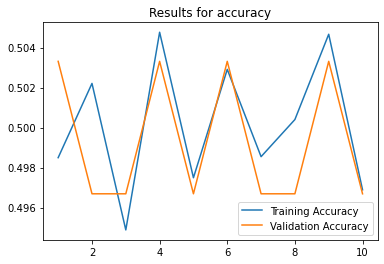

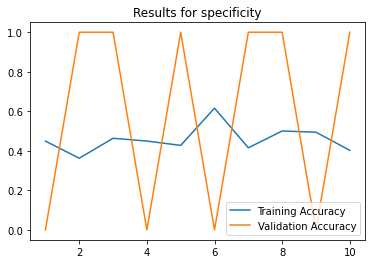

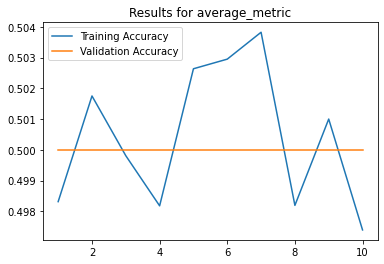

In [27]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
for i in ['accuracy', 'specificity', 'average_metric']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

## Conclusion

Various attempts were made to tune our RNN model, to no avail. Even both LSTM and GRU were used. The results remain puzzling. If we had more time, we might be able to figure out how to tune our RNN model. For now, our best model would be our Logistic Regression with TF-IDF vectorizer. Please refer back to notebook 3 (Machine Learning Models) for the results and further conclusion and evaluation.

Future improvements to this project, other than tuning our RNN model, would be to consider using other deep learning models as well. These include models with word2vec embeddings, and pre-trained ones, like BERT.